# Relaxing an Al (1 1 1) surface under an electric field using SPHInX

If you make use of this notebook and/or its recipes, please consider citing the following (for which this notebook has been distributed as supporting material):

> Christoph Freysoldt, Arpit Mishra, Michael Ashton, and Jörg Neugebauer, *Generalized dipole correction for charged surfaces in the repeated-slab approach*, Phys. Rev. B **102**, 045403

The goal of this notebook is to give a very simple example for using the generalized dipole correction (outlined in detail within the above paper) within the [SPHInX](https://sxrepo.mpie.de) DFT program.

As one of the simplest use cases, we will add an electric field to both sides of a very thin Al (111) slab and relax the slab. The electric potential in the DFT cell will be plotted at the end of the notebook so you can visualize the generalized dipole correction as it is described in the paper.

The calculations and analysis are performed using [pyiron](https://pyiron.org). For more details on specific commands/options in pyiron or SPHInX, please consult their individual documentation and tutorials.

In [1]:
from pyiron import Project
from pyiron_atomistics.sphinx.base import Group

import os

import numpy as np

import matplotlib.pylab as plt

### Create the job

In [2]:
pr = Project("ChargedRelax")
job = pr.create_job(
    job_type=pr.job_type.Sphinx,
    job_name="Al_111"
)

### Build an Al (1 1 1) surface and assign it to the job

In [3]:
job.structure = pr.create_surface("Al", "fcc111", size=[1,1,4], vacuum=10)
job.structure.add_tag(selective_dynamics=(True, True, True))

In [4]:
job.structure.plot3d()

NGLWidget()

### Freeze the bottom half of the slab

In [5]:
job.structure.selective_dynamics[
    range(len(job.structure)//2)
] = (False, False, False)

### Set up the DFT input for a basic geometry optimization

In [6]:
job.calc_minimize()

### Modify energy cutoff and k-points for a surface calculation

Feel free to use lower settings to get the calculation to run faster on MyBinder, which is a free-to-use server!

In [7]:
job.set_encut(400)  # in eV
job.set_kpoints([9, 9, 1], center_shift=[0.5, 0.5, 0.25])

### Charge the bottom layer of atoms
In this case, we are targeting a specific field on the right and left sides of the slab (`right_field` and `left_field`, respectively). The following cell calculates the charge required to create this field and then distributes this charge evenly across all "bottom" (leftmost) atoms of the slab for the initial density.

In [8]:
HARTREE_TO_EV = 27.2114
ANGSTROM_TO_BOHR = 1.8897

# atomic units (1 E_h/ea_0 ~= 51.4 V/Å)
right_field = 0.05
left_field = -0.025

cell = job.structure.cell * ANGSTROM_TO_BOHR
area = np.linalg.norm(np.cross(cell[0], cell[1]))

total_charge = (right_field - left_field) * area / (4 * np.pi) # Eqn. 3 from Freysoldt, et al.

positions = [p[2] for p in job.structure.positions]
job.input.sphinx.initialGuess.rho.charged = Group({})
job.input.sphinx.initialGuess.rho.charged.charge = total_charge
job.input.sphinx.initialGuess.rho.charged.z = min(positions)

### Add the dipole correction to the PAWHamiltonian group

The `z_field` parameter in the `PAWHamiltonian` input group controls the "excess" field that should remain on the other side of the dipole correction layer, i.e. the field that will exist on the bottom (left) side of the slab.

In [9]:
job.input.sphinx.PAWHamiltonian.nExcessElectrons = -total_charge
job.input.sphinx.PAWHamiltonian.dipoleCorrection = True
job.input.sphinx.PAWHamiltonian.zField = left_field * HARTREE_TO_EV

### Run the job

In [10]:
job.run(run_again=True)

<ipython-input-10-ae9f2db87acf>:1: DeprecationWarning: pyiron_base.job.generic.run(run_again=True) is deprecated. It is not guaranteed to be in service in vers. 0.4.0
  job.run(run_again=True)


The job Al_111 was saved and received the ID: 1


### Plot the electrostatic potential
Uncomment the commented lines to plot the expected fields on top of the potential.

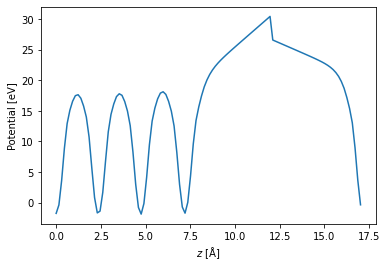

In [11]:
v_electrostatic = job.get_electrostatic_potential()
planar_avg = v_electrostatic.get_average_along_axis(2)

x = np.linspace(0, job.structure.cell[2][2], len(planar_avg))

# ind_0 = np.argwhere(x > 9)[0]
# ind_dipole = np.argmax((2 * planar_avg - np.roll(planar_avg, 1) - np.roll(planar_avg, -1))[np.abs(x - 12) < 3]) + ind_0
# m_dipole = x[ind_dipole+1]

# E_right = right_field * 51.4 * (x - m_dipole) + planar_avg[ind_dipole]
# E_left = left_field * 51.4 * (x - m_dipole) + planar_avg[ind_dipole + 1]

# plt.axvline(m_dipole, color="k")
# plt.plot(x, E_right, 'k--')
# plt.plot(x, E_left, 'k--')

plt.plot(x, planar_avg)
plt.xlabel('$z$ [Å]')
plt.ylabel('Potential [eV]')
plt.show()